(reglin-pymc-notebook)=
# Analisi bayesiana del modello di regressione lineare bivariato

Nel presente capitolo, esploreremo l'analisi bayesiana applicata al modello di regressione lineare bivariato. 

## Preparazione del Notebook

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from IPython import get_ipython
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import cmdstanpy

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from cmdstanpy import CmdStanModel
import pingouin as pg

# set seed to make the results fully reproducible
seed: int = sum(map(ord, "ds4p"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory
project_directory = os.path.join(home_directory, "_repositories", "ds4p")

# Configure the inline backend for Jupyter notebooks
ipython = get_ipython()
if ipython is not None:
    ipython.run_line_magic("config", "InlineBackend.figure_format = 'retina'")

## Modellare l'associazione statistica tra variabili

Per introdurre l'approccio bayesiano al modello di regressione, esamineremo un set di [dati](https://www.bgsu.edu/content/dam/BGSU/nwo/documents/COMP-6-8/June21_2016/IcecreamSalesvsTemperature.pdf) che riguarda la relazione tra la temperatura media e gli introiti (in dollari) di un particolare negozio di gelati. Sebbene questa possa non sembrare una questione scientifica particolarmente entusiasmante, è un esempio semplice e intuitivo da analizzare. La relazione tra consumo di gelati e temperatura può apparire banale, ma offre una chiara opportunità per comprendere i meccanismi alla base dell'associazione tra due variabili. In questo momento, ci concentreremo esclusivamente sui metodi per stimare tale associazione.

In precedenza, abbiamo applicato il modello Normale ad una singola variabile. Tuttavia, di solito siamo interessati a modellare come una variabile di esito sia correlata a un'altra variabile predittiva. Se la variabile predittiva ha una qualche associazione statistica con la variabile di esito, possiamo utilizzarla per predire il risultato. Quando la variabile predittiva è integrata nel modello in un modo specifico, otteniamo una regressione lineare.

I dati dell'esempio sono forniti di seguito.

In [2]:
data = {
    "temperature": [
        14.2,
        16.4,
        11.9,
        15.2,
        18.5,
        22.1,
        19.4,
        25.1,
        23.4,
        18.1,
        22.6,
        17.2,
    ],
    "icecream": [215, 325, 185, 332, 406, 522, 412, 614, 544, 421, 445, 408],
}

# Create a DataFrame
df = pd.DataFrame(data)
df.head()

,temperature,icecream
0,14.2,215
1,16.4,325
2,11.9,185
3,15.2,332
4,18.5,406


L'associazione tra le due variabili (gli introiti derivanti dalla vendita di gelati e la temperatura) è chiaramente visualizzata nel grafico seguente. Il grafico indica che l'associazione tra le due variabili può essere approssimata da una semplice funzione matematica, ovvero una retta. Tuttavia, è evidente che una funzione lineare sia troppo semplice per rappresentare accuratamente questi dati: non è possibile trovare una singola retta che passi per tutti i punti del diagramma di dispersione.

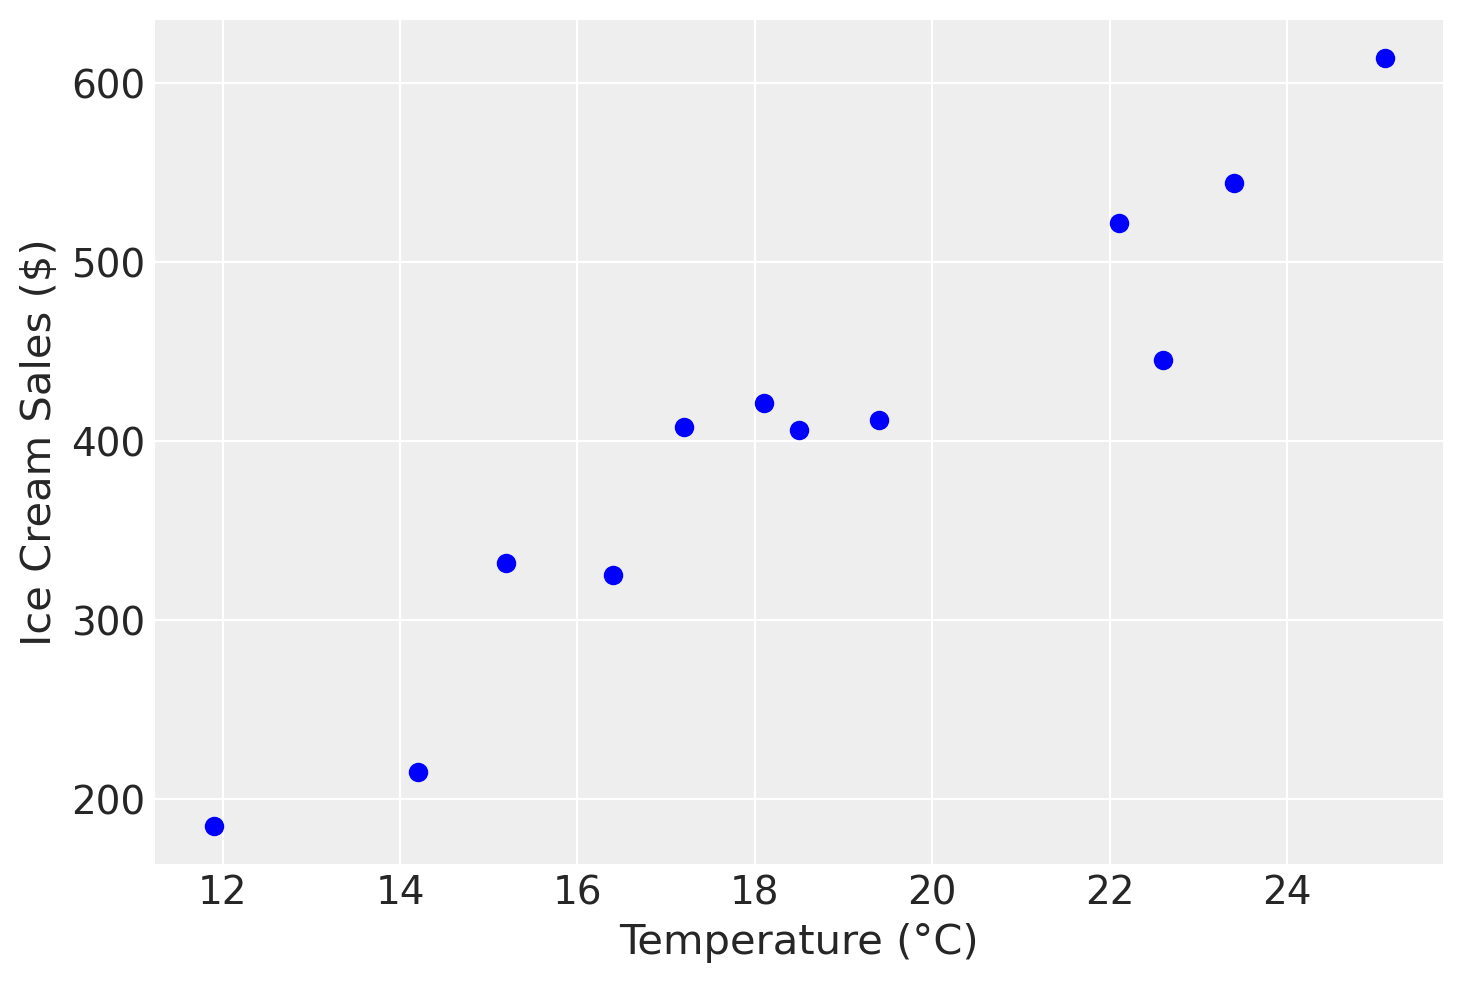

In [3]:
plt.scatter(df["temperature"], df["icecream"], color="blue")
plt.xlabel("Temperature (°C)")
plt.ylabel("Ice Cream Sales ($)")
plt.grid(True)
plt.show()

## Modello Generativo dei Dati

Per descrivere la relazione tra introiti e temperatura, utilizzeremo un modello statistico lineare. Assumeremo che la relazione media tra $x$ (temperatura) e $y$ (introiti) possa essere rappresentata da una retta, ma influenzata da un certo grado di errore. Supponiamo che questo errore sia costante ai vari livelli di $x$ e segua una distribuzione Normale. Inoltre, presupponiamo che gli errori attorno alla retta di regressione siano indipendenti tra loro.

In questo contesto, le nostre assunzioni delineano un modello statistico lineare, formalizzato come segue:

$$ y_i = \alpha + \beta x_i + \epsilon_i $$

dove:
- $\alpha$ è l'intercetta,
- $\beta$ è il coefficiente angolare,
- $\epsilon_i \sim \text{Normale}(0, \sigma^2)$ rappresenta l'errore, con media zero e varianza costante $\sigma^2$.

Queste assunzioni ci permettono di applicare metodi di regressione lineare per stimare i parametri del modello ($\alpha$ e $\beta$) e quantificare l'incertezza delle predizioni, considerando la variabilità nei dati.

Il modello lineare descritto sopra costituisce il modello generativo dei dati (verosimiglianza):

$$ y_n = \alpha + \beta x_n + \epsilon_n $$

o equivalentemente

$$ \epsilon_n \sim \text{Normale}(0, \sigma) $$

Questo modello descrive come i dati $ y_n $ sono generati. Ogni osservazione $ y_n $ è una combinazione lineare di una costante $\alpha$ (intercetta), un coefficiente $\beta$ che moltiplica il valore della variabile $ x_n $ (temperatura), e un termine di errore $\epsilon_n$ che cattura la variabilità non spiegata dal modello lineare.

Il termine di errore $\epsilon_n$ è distribuito secondo una distribuzione normale con media 0 e deviazione standard $\sigma$. Questo implica che l'errore è simmetricamente distribuito attorno a zero e ha una variabilità definita da $\sigma$.

L'equazione

$$ y_n \sim \text{Normale}(\alpha + \beta x_n, \sigma) $$

mostra come il valore osservato $ y_n $ segue una distribuzione normale con media $\alpha + \beta x_n$ e deviazione standard $\sigma$. Questo significa che, dato $ x_n $, i valori di $ y_n $ sono distribuiti normalmente attorno alla retta di regressione definita da $\alpha + \beta x_n$.

Consideriamo il caso in cui $ y_n $ rappresenta le vendite di gelati e $ x_n $ rappresenta la temperatura media. Secondo il nostro modello:

- **$\alpha$** è l'intercetta, ovvero le vendite di gelati previste quando la temperatura è zero.
- **$\beta$** è il coefficiente che indica quanto aumentano (o diminuiscono) le vendite di gelati per ogni aumento di un grado della temperatura.
- **$\sigma$** è la deviazione standard che misura la variabilità delle vendite di gelati attorno alla media prevista dal modello.

Questo modello ci consente di stimare l'effetto della temperatura sulle vendite di gelati e di quantificare l'incertezza associata a queste stime.

## Modello Bayesiano della Regressione Bivariata

### Verosimiglianza

Assumiamo la verosimiglianza che abbiamo descritto in precedenza:

$$ y \sim \text{Normale}(\alpha + \beta x, \sigma) $$

Questo significa che i dati $ y $ seguono una distribuzione normale con media $\alpha + \beta x$ e deviazione standard $\sigma$. In altre parole, il valore osservato $ y $ è generato come una combinazione lineare di $\alpha$ (intercetta), $\beta$ (coefficiente della variabile $ x $), più un errore che segue una distribuzione normale con deviazione standard $\sigma$.

### Distribuzioni a Priori

In una prima versione del modello, useremo delle distribuzioni a priori uniformi per i tre parametri.

### Distribuzioni a Posteriori

Le distribuzioni a priori vengono combinate con i dati osservati attraverso il teorema di Bayes per aggiornare le nostre credenze sui parametri del modello. Il risultato è una distribuzione a posteriori per ciascun parametro che riflette sia l'informazione contenuta nei dati che le credenze iniziali incorporate nelle distribuzioni a priori. Questo processo permette di fare inferenze più robuste, specialmente quando i dati sono limitati o rumorosi.

### Codice Stan

Il codice Stan che implementa il modello precedente è contenuto nel file `icecream_model_1.stan`. Compiliamo e stampiamo il modello.

In [4]:
stan_file = os.path.join(project_directory, 'stan', 'icecream_model_1.stan')
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}



Si noti che, non avendo specificato le distribuzioni a priori per i parametri $\alpha$, $\beta$ e $\sigma$, Stan assume distribuzioni a priori uniformi.

### Dizionario con i dati

Sistemiamo i dati in un dizionario come richiesto dal modello Stan.

In [5]:
stan_data = {
    "N": len(df["temperature"]),
    "x": df["temperature"],
    "y": df["icecream"]
}
print(stan_data)

{'N': 12, 'x': 0     14.2
1     16.4
2     11.9
3     15.2
4     18.5
5     22.1
6     19.4
7     25.1
8     23.4
9     18.1
10    22.6
11    17.2
Name: temperature, dtype: float64, 'y': 0     215
1     325
2     185
3     332
4     406
5     522
6     412
7     614
8     544
9     421
10    445
11    408
Name: icecream, dtype: int64}


### Campionamento MCMC

Eseguiamo il campionamento MCMC.

In [6]:
fit = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

### Distribuzioni a posteriori

Esaminiamo le distribuzioni a posteriori dei parametri.

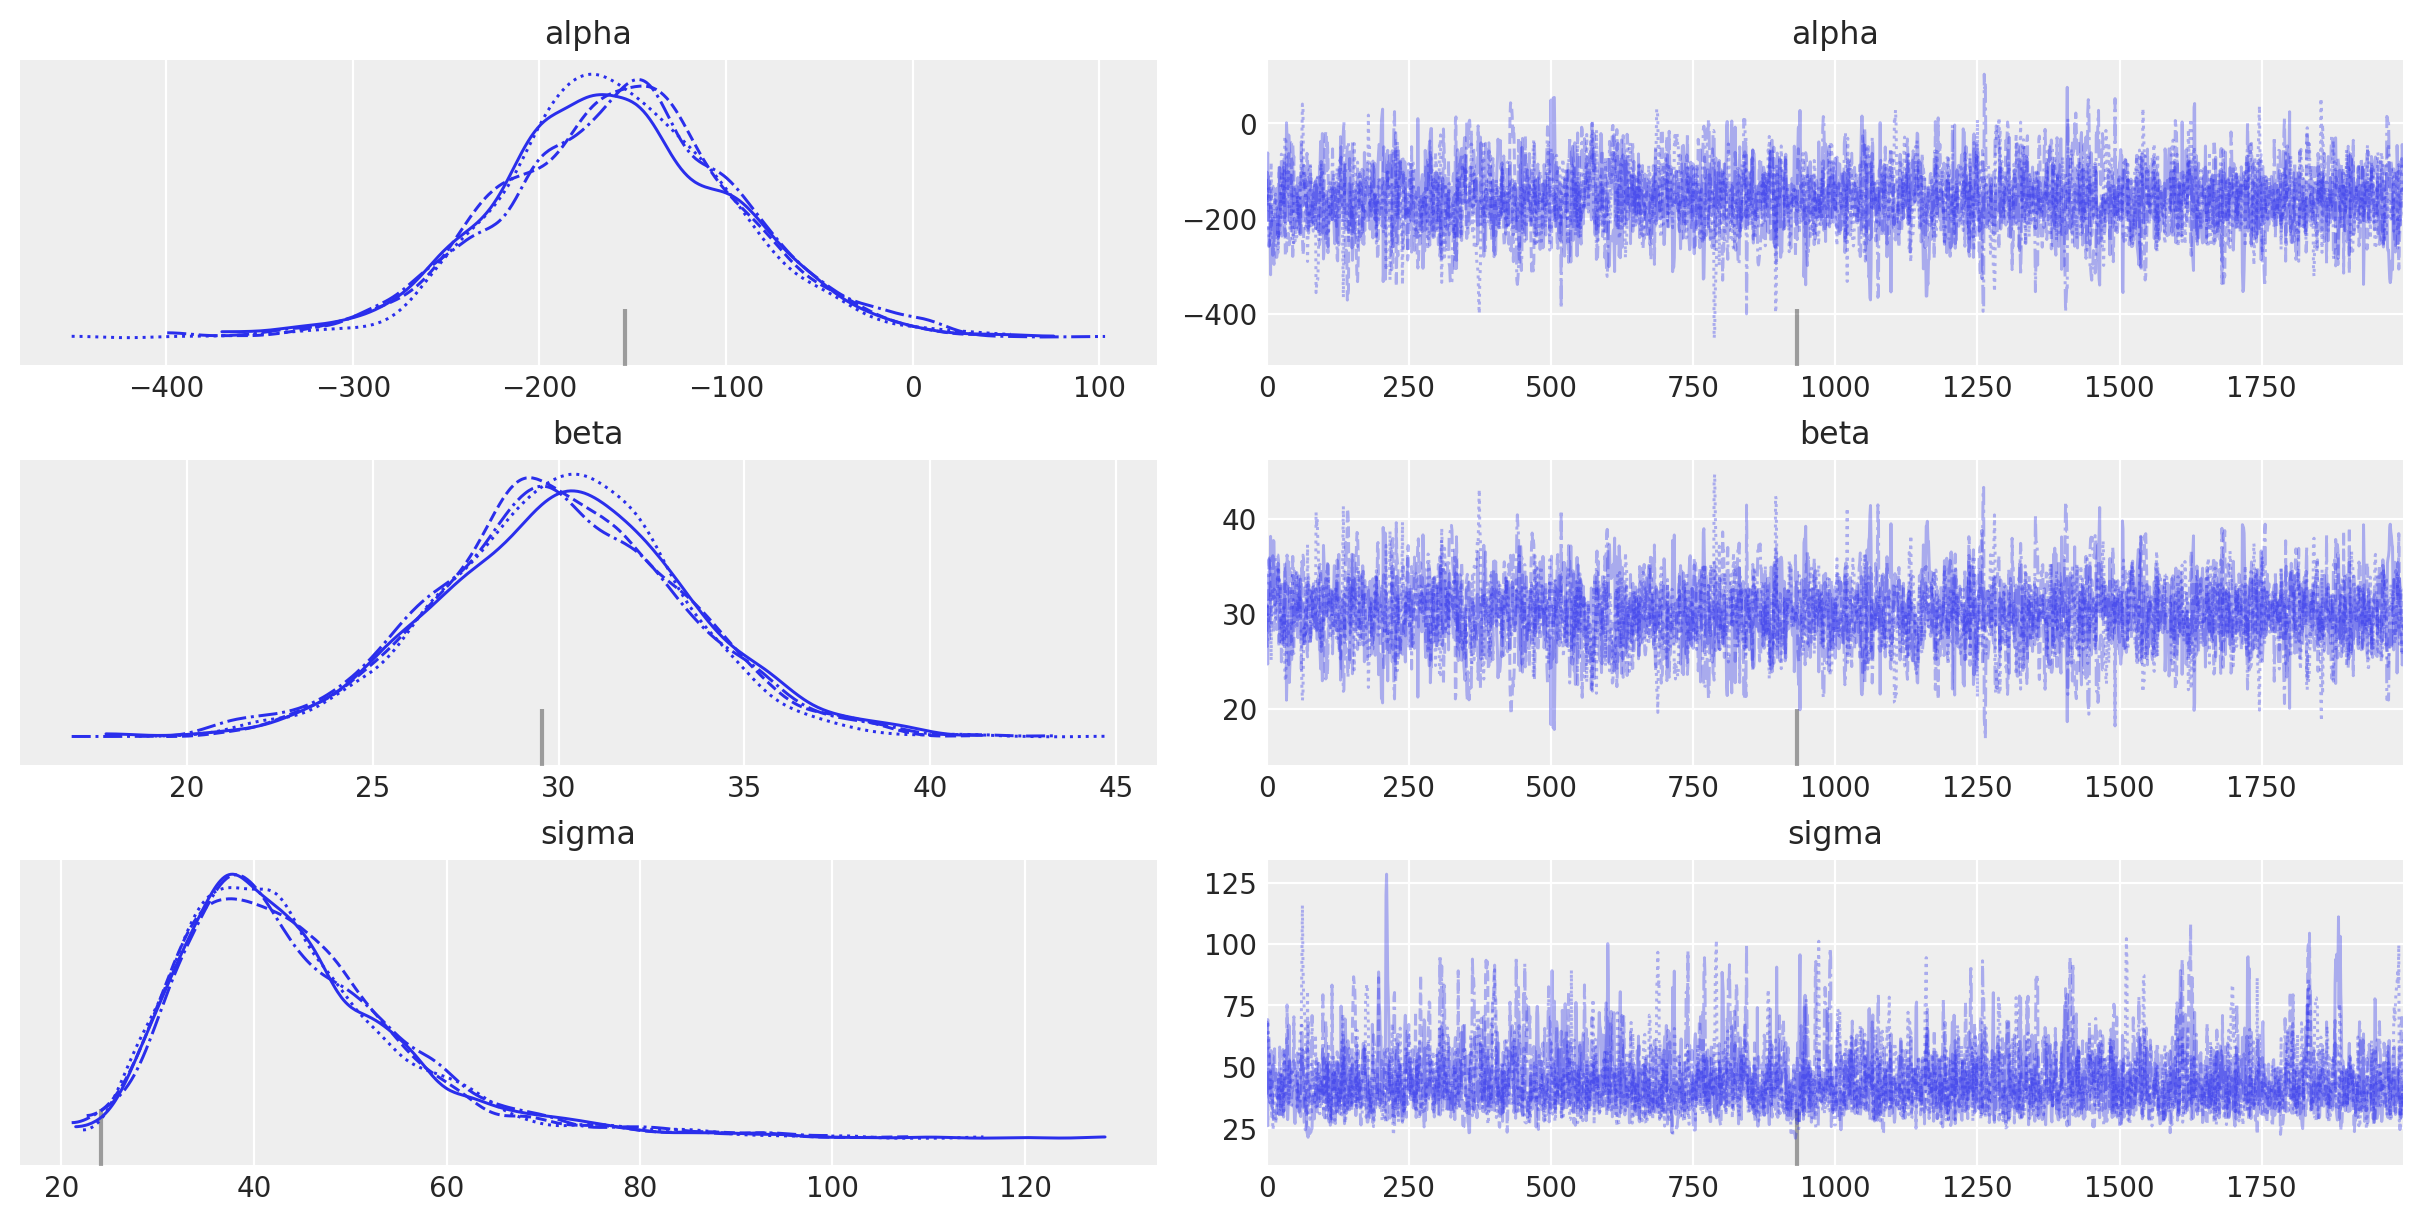

In [7]:
_ = az.plot_trace(fit, var_names=(["alpha", "beta", "sigma"]))

L'oggetto `fit` generato da `cmdstanpy` appartiene alla classe `cmdstanpy.stanfit.mcmc.CmdStanMCMC`. Questo oggetto è funzionalmente equivalente a un oggetto della classe `InferenceData`, permettendo quindi la sua manipolazione tramite le funzioni fornite da ArviZ. Esaminiamo dunque un sommario delle distribuzioni a posteriori dei parametri del modello lineare.

In [8]:
az.summary(fit, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-158.315,64.516,-271.588,-28.269,1.429,1.010,2051.0,2311.0,1.0
beta,30.032,3.372,23.574,36.268,0.074,0.053,2065.0,2329.0,1.0
sigma,44.162,12.121,25.540,66.813,0.270,0.195,2120.0,2226.0,1.0


Avendo definito nel modello il predittore lineare come $x - \bar{x}$, l'intercetta corrisponderà alla media dei valori dell'altezza. La pendenza $\beta$ ci informa sull'incremento atteso dell'altezza quando il peso aumenta di un'unità. Il parametro $\sigma$ descrive la deviazione standard della dispersione dei dati attorno alla retta di regressione.

Confrontiamo i valori ottenuti con l'approccio bayesiano con quelli trovati usando la procedura di massima verosimiglianza.

In [9]:
lm = pg.linear_regression(df["temperature"], df["icecream"])
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-159.47,54.64,-2.92,0.02,0.92,0.91,-281.22,-37.73
1,temperature,30.09,2.87,10.50,0.00,0.92,0.91,23.70,36.47


La somiglianza tra le due soluzioni conferma che, nel caso di modelli semplici come questo, e quando vengono usati dei prior non informativi, i due approcci producono risultati sostanzialmente equivalenti.

### Interpretazione

Possiamo interpretare i parametri come segue:

- La media a posteriori di $\alpha = -159.47$ indica che il valore atteso degli introiti del negozio di gelati è di -159.47 dollari quando la temperatura è di 0 gradi centigradi.
- La media a posteriori di $\beta = 30.09$ suggerisce che ci aspettiamo un aumento medio di 30.09 dollari negli introiti del negozio di gelati per ogni incremento di 1 grado centigrado nella temperatura.

## Predizione

La distribuzione a posteriori non contiene solo informazioni su ciascun parametro singolarmente, ma anche sulle dipendenze tra i parametri. Queste dipendenze sono riflesse nei campioni a posteriori che possono essere trasformati arbitrariamente.

Ad esempio, supponiamo che `alpha` e `beta` siano vettori di campioni a posteriori.

Con l'istruzione seguente nel blocco `generated quantities`, possiamo calcolare la predizione a posteriori per 30 gradi Celsius:

`pred = alpha + beta * 30;`

Modifichiamo il modello Stan per aggiungere il blocco `generated quantities` con questa istruzione e compiliamo il modello.

In [10]:
stan_file = os.path.join(project_directory, "stan", "icecream_model_2.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}
generated quantities {
  real pred; // predizione
  
  pred = alpha + beta * 30;
}



In questo modello Stan aggiornato, il blocco `generated quantities` calcola la predizione a posteriori `pred` per una variabile predittore con valore 30. Questa aggiunta consente di ottenere la distribuzione a posteriori della predizione per un determinato valore del predittore.

Eseguiamo il campionamento.

In [11]:
fit2 = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo la stima a posteriori dell'introito previsto per il negozio di gelati quando la temperatura raggiunge i 30 gradi Celsius. Questa analisi fornirà sia una stima puntuale dell'introito che una misura dell'incertezza associata, rappresentata dall'intervallo di credibilità al livello di confidenza prescelto.

In [12]:
az.summary(fit2, var_names=(["pred"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred,742.651,40.123,664.016,816.924,0.818,0.579,2409.0,3196.0,1.0


### Quantificazione dell'incertezza

Per quantificare l'incertezza nelle predizioni del modello, possiamo estendere il metodo esaminato in precedenza per calcolare la distribuzione a posteriori delle predizioni per tutti i valori di $x$ considerati. Questo ci permette di ottenere non solo le stime puntuali delle predizioni, ma anche una misura dell'incertezza associata a ciascuna predizione.

Per fare ciò, modifichiamo il blocco `generated quantities` nel seguente modo:

```stan
generated quantities {
  vector[N] y_rep; // predizioni a posteriori per ciascun valore di x
  
  for (n in 1:N) {
    y_rep[n] = normal_rng(alpha + beta * x[n], sigma);
  }
}
```

Esaminiamo nei dettagli la modifica allo script Stan.

1. **Dichiarazione del vettore `y_rep`**:
   - `vector[N] y_rep;`: Questa linea dichiara un vettore `y_rep` di lunghezza `N` che conterrà le predizioni a posteriori per ciascun valore di `x`.

2. **Ciclo `for` per generare le predizioni**:
   - `for (n in 1:N)`: Questo ciclo iterativo va da `1` a `N`, cioè copre tutte le osservazioni.
   - `y_rep[n] = normal_rng(alpha + beta * x[n], sigma);`: Per ogni valore di `x[n]`, questa linea genera una predizione dalla distribuzione normale con media `alpha + beta * x[n]` e deviazione standard `sigma`. La funzione `normal_rng` è utilizzata per generare numeri casuali dalla distribuzione normale specificata, rappresentando così l'incertezza nelle predizioni.

- Questo approccio consente di ottenere la distribuzione a posteriori delle predizioni, fornendo una visione completa dell'incertezza associata a ciascuna predizione.

- Dalla distribuzione a posteriori di `y_rep`, possiamo calcolare sia la stima puntuale (ad esempio, la media o la mediana delle predizioni) sia gli intervalli di credibilità (ad esempio, l'intervallo al 95%) per ogni valore di `x`. Questo offre una misura dell'incertezza delle predizioni, riflettendo la variabilità e l'affidabilità del modello.

In sintesi, questa modifica ci permette di valutare l'incertezza delle predizioni del modello in modo robusto e dettagliato, migliorando la comprensione della performance del modello e della sua capacità predittiva.

In [13]:
stan_file = os.path.join(project_directory, "stan", "icecream_model_3.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}
generated quantities {
  vector[N] y_rep; // variabili predette
  
  for (n in 1 : N) {
    y_rep[n] = normal_rng(alpha + beta * x[n], sigma);
  }
}



In [14]:
fit3 = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Costruiamo ora un grafico che rappresenta i valori osservati insieme alla linea di regressione stimata tramite il modello bayesiano. Al grafico aggiungeremo diverse linee di regressione, ciascuna orientata in base ai valori campionati casualmente dalla distribuzione a posteriori dei parametri $\alpha$ e $\beta$.

In [15]:
# Extract posterior samples
alpha_samples = fit3.stan_variable("alpha")
beta_samples = fit3.stan_variable("beta")

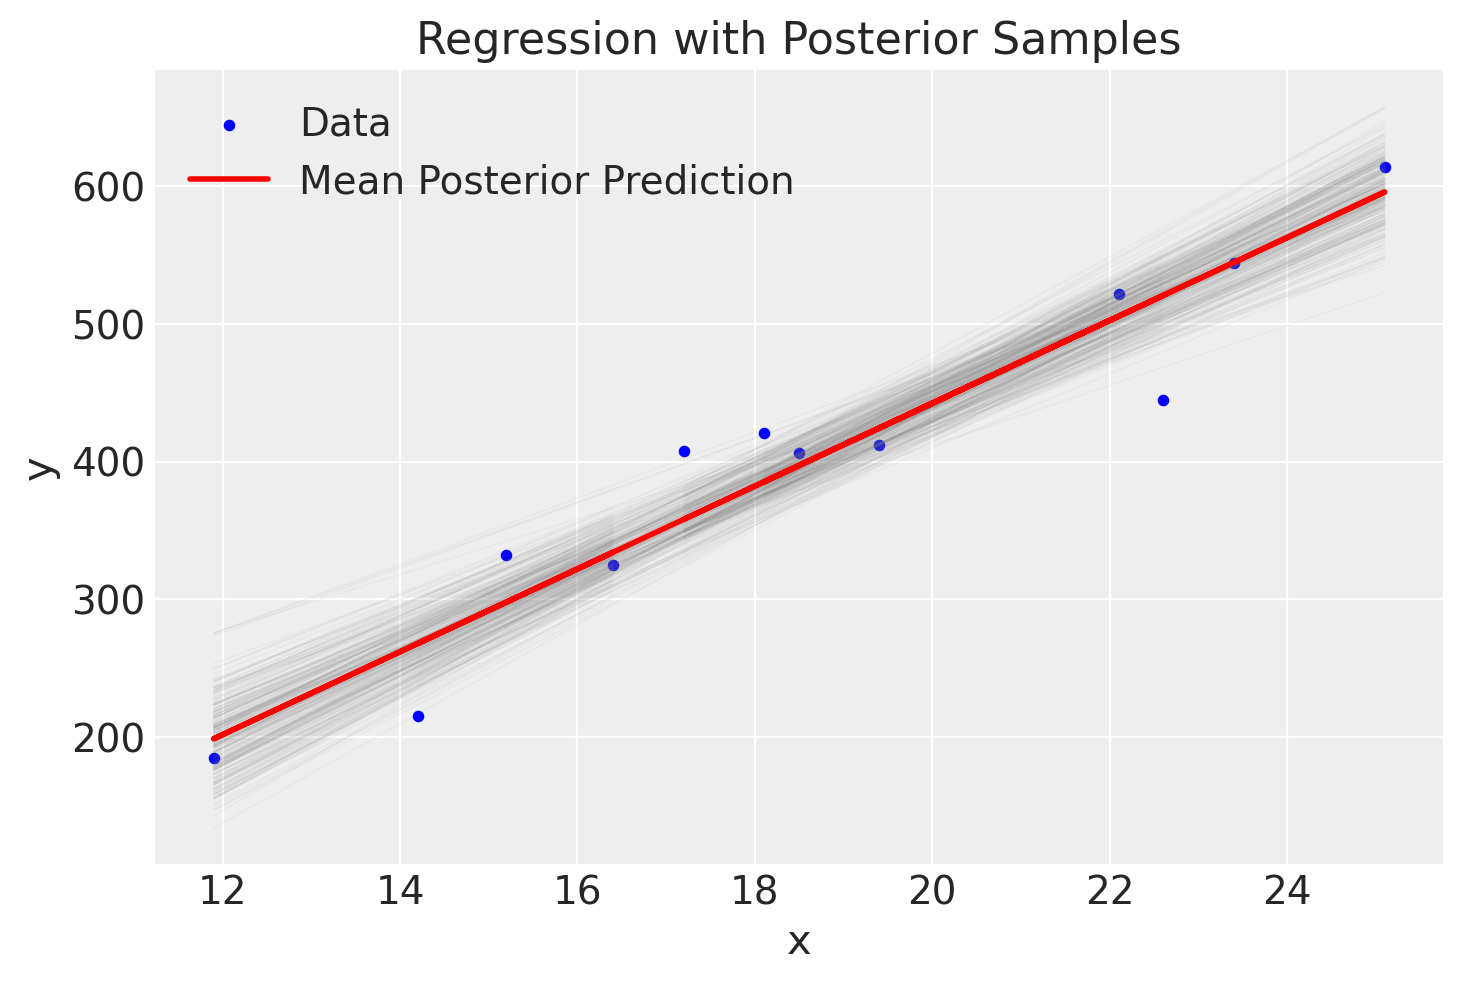

In [16]:
# Plot y vs x
x = df["temperature"] 
plt.scatter(x, df["icecream"], color="blue", label="Data", s=10)  # s is the size of the point

# Draw lines from posterior samples
for i in range(300):  # assuming you have at least 300 samples
    plt.plot(
        x,
        alpha_samples[i] + beta_samples[i] * x,
        color="gray",
        linestyle="-",
        linewidth=0.5,
        alpha=0.05,
    )

# Line using the mean of posterior estimates
mean_alpha = np.mean(alpha_samples)
mean_beta = np.mean(beta_samples)
plt.plot(
    x,
    mean_alpha + mean_beta * x,
    color="red",
    linewidth=2,
    label="Mean Posterior Prediction",
)

# Additional plot formatting
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression with Posterior Samples")
plt.legend()
plt.show()

Le numerose linee di regressione presenti nel grafico visualizzano la nostra incertezza riguardo l'inclinazione esatta della linea di regressione principale. Tuttavia, il grafico mostra chiaramente che questa incertezza è minima.

Possiamo procedere in un altro modo per descrivere l'incertezza della stima. Anziché utilizzare le distribuzioni a posteriori di `alpha` e `beta`, possiamo utilizzare la distribuzione a posteriori di `y_rep`. Procedendo in questo modo otteniamo il grafico mostrato qui sotto.

In questo plot, la linea rossa rappresenta la media delle predizioni a posteriori, mentre l'area grigia rappresenta l'intervallo di credibilità al 95%, mostrando l'incertezza delle predizioni del modello. Questo approccio fornisce una visione più completa e realistica dell'incertezza nelle predizioni rispetto all'approccio che utilizza solo `alpha` e `beta`.

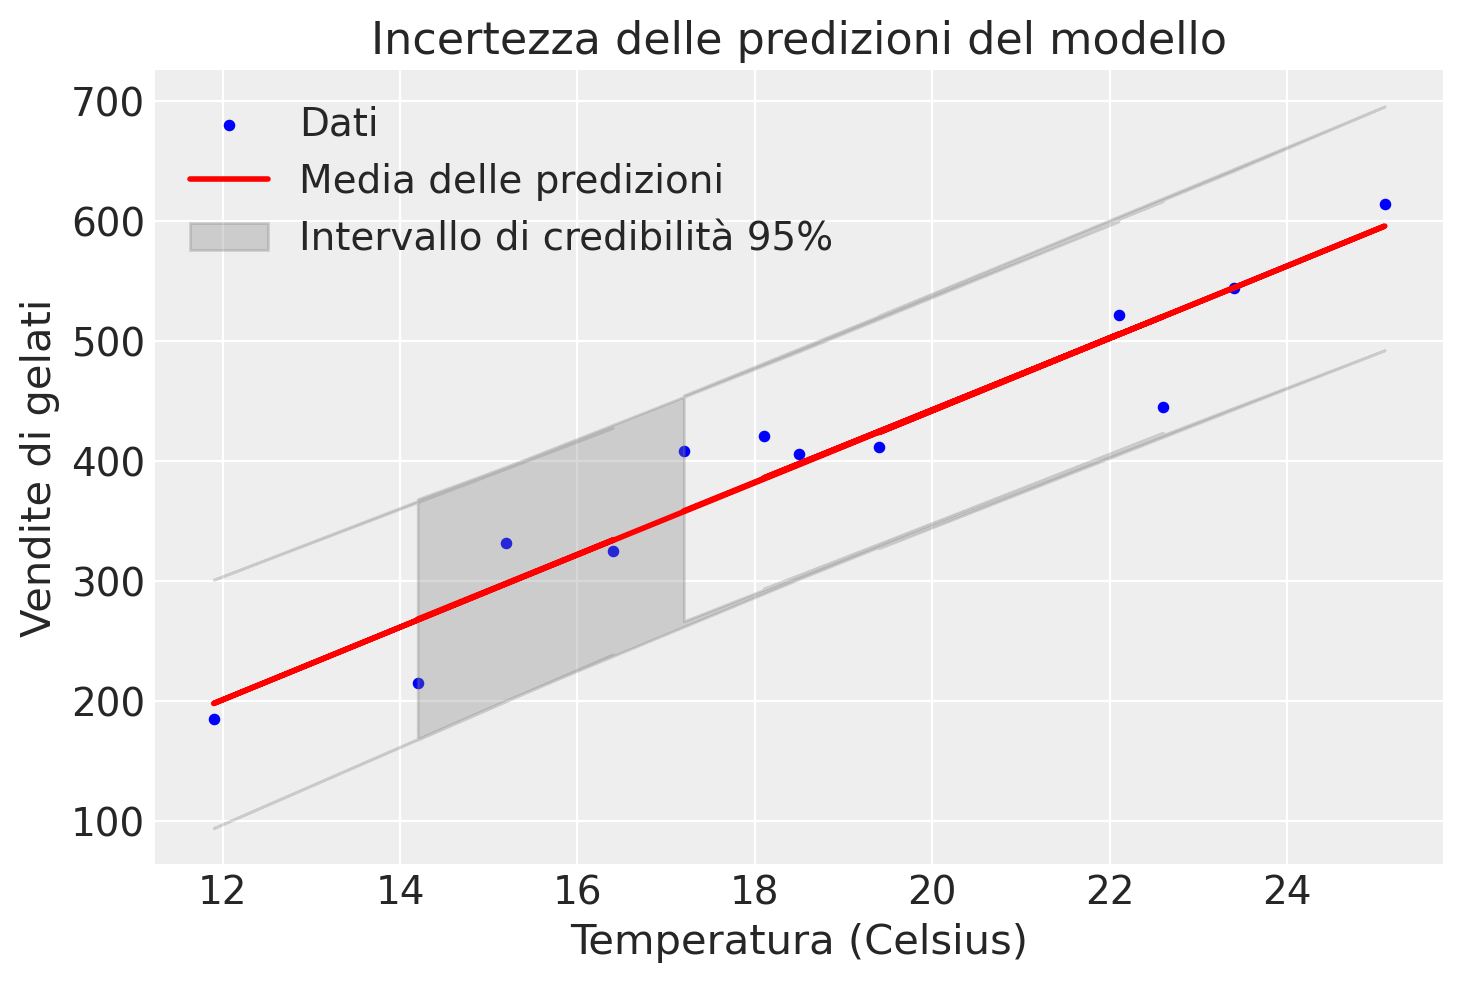

In [17]:
# Estrai i campioni posteriori di y_rep
y_rep_samples = fit3.stan_variable("y_rep")

# Calcola la media e l'intervallo di credibilità (ad esempio, 95%) per y_rep
y_rep_mean = np.mean(y_rep_samples, axis=0)
y_rep_lower = np.percentile(y_rep_samples, 2.5, axis=0)
y_rep_upper = np.percentile(y_rep_samples, 97.5, axis=0)

# Plot y vs x
x = df["temperature"]
y = df["icecream"]
plt.scatter(x, y, color="blue", label="Dati", s=10)

# Plot della media delle predizioni a posteriori
plt.plot(x, y_rep_mean, color="red", linewidth=2, label="Media delle predizioni")

# Plot dell'intervallo di credibilità
plt.fill_between(
    x,
    y_rep_lower,
    y_rep_upper,
    color="gray",
    alpha=0.3,
    label="Intervallo di credibilità 95%",
)

# Formattazione del plot
plt.xlabel("Temperatura (Celsius)")
plt.ylabel("Vendite di gelati")
plt.title("Incertezza delle predizioni del modello")
plt.legend()
plt.show()

Nel primo approccio, calcoliamo l'incertezza delle predizioni utilizzando le distribuzioni a posteriori di `alpha` e `beta`. Questo metodo consiste nel generare predizioni lineari per ciascun campione a posteriori di `alpha` e `beta`, tracciando quindi le linee di regressione risultanti. Questo ci permette di vedere come varia la linea di regressione in base alle incertezze nei parametri `alpha` e `beta`. Questo metodo visualizza come l'incertezza nei parametri del modello si traduce in incertezza nelle predizioni.

Nel secondo approccio, descriviamo l'incertezza delle predizioni utilizzando direttamente la distribuzione a posteriori di `y_rep`. In questo caso, generiamo predizioni per ciascun valore osservato di `x` nel modello Stan, tenendo conto delle distribuzioni a posteriori dei parametri del modello. Questo metodo visualizza direttamente l'incertezza nelle predizioni, tenendo conto delle variazioni nei dati osservati e delle distribuzioni a posteriori dei parametri.

Le due descrizioni dell'incertezza delle predizioni del modello sono diverse perché riflettono aspetti differenti della distribuzione a posteriori:

1. **Distribuzione a posteriori di `alpha` e `beta`**: Questo approccio considera solo l'incertezza nei parametri del modello (`alpha` e `beta`). Le linee di regressione tracciate variano in base a questi parametri, ma non tengono conto dell'incertezza residua (`sigma`).

2. **Distribuzione a posteriori di `y_rep`**: Questo approccio include non solo l'incertezza nei parametri `alpha` e `beta`, ma anche l'incertezza residua (`sigma`). La distribuzione di `y_rep` riflette la variabilità totale nel modello, inclusa la variabilità nei dati osservati. Pertanto, l'incertezza nelle predizioni è maggiore perché tiene conto di tutte le fonti di variabilità.

## Ricodifica dei dati

L'intercetta ($\alpha$) corrisponde al valore atteso degli introiti quando la temperatura è di 0 gradi centigradi. Un valore negativo dell'intercetta indica che, in tali circostanze, ci aspettiamo una perdita. Tuttavia, possiamo ricodificare i dati in modo che l'intercetta abbia un'interpretazione più utile.

### Centratura della variabile $ x $

Centriamo la variabile $ x $ (temperatura), sottraendo la media della temperatura ($\bar{x}$) da ciascun valore di $ x $. In questo modo otteniamo la nuova variabile $ xc $ la cui media è 0. La trasformazione è definita come:

$$ xc_i = x_i - \bar{x} $$

Dove $\bar{x}$ è la media della temperatura.

### Interpretazione della nuova intercetta

Il valore 0 di $ xc $ corrisponde al valore medio di $ x $. Dato che la retta di regressione passa per il punto $(\bar{x}, \bar{y})$, se utilizziamo $ xc $ al posto di $ x $, la nuova intercetta ($\alpha$) ci dirà qual è il valore atteso degli introiti ($ y $) quando la temperatura assume il suo valore medio ($\bar{x}$).

In [18]:
# Calcolo della temperatura media
mean_temp = df["temperature"].mean()

# Creazione della variabile centrata
df["temp_c"] = df["temperature"] - mean_temp

In [19]:
stan_data2 = {"N": len(df["temp_c"]), "x": df["temp_c"], "y": df["icecream"]}
print(stan_data2)

{'N': 12, 'x': 0    -4.475
1    -2.275
2    -6.775
3    -3.475
4    -0.175
5     3.425
6     0.725
7     6.425
8     4.725
9    -0.575
10    3.925
11   -1.475
Name: temp_c, dtype: float64, 'y': 0     215
1     325
2     185
3     332
4     406
5     522
6     412
7     614
8     544
9     421
10    445
11    408
Name: icecream, dtype: int64}


In [20]:
fit4 = model.sample(
    data=stan_data2,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

In [21]:
az.summary(fit4, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,402.356,13.079,377.577,426.508,0.166,0.117,6454.0,4831.0,1.0
beta,30.093,3.398,23.867,36.725,0.047,0.033,5538.0,4353.0,1.0
sigma,43.766,11.651,26.153,66.129,0.180,0.128,4437.0,5027.0,1.0


Notiamo che la media a posteriori di $\beta$ è rimasta invariata. Tuttavia, la media a posteriori di $\alpha$ è ora pari a 402,4 dollari. Questo rappresenta il valore atteso degli introiti del negozio di gelati quando la temperatura è al suo valore medio.

## Distribizioni a priori sui parametri

Spefichiamo ora le seguenti distribuzioni a priori debolmente informative sui parametri del modello.

1. **Intercetta ($\alpha$)**:
   - $\alpha \sim \text{Normale}(0, 100)$
   - La scelta di una deviazione standard ampia (100) riflette l'incertezza riguardo al valore iniziale dell'intercetta. Si crede che l'intercetta possa essere qualsiasi valore vicino a 0, ma con una variazione significativa.

2. **Coefficiente Angolare ($\beta$)**:
   - $\beta \sim \text{Normale}(0, 50)$
   - Un'ampia deviazione standard (50) per $\beta$ permette di incorporare l'incertezza riguardo all'influenza della temperatura sui ricavi del gelato. Questo prior permette che $\beta$ possa essere sia positivo che negativo con una vasta gamma di valori.

3. **Deviazione Standard Residua ($\sigma$)**:
   - $\sigma \sim \text{Cauchy}^+(0, 5)$
   - La distribuzione Half-Cauchy è scelta perché è debolmente informativa e adatta per i parametri di scala come la deviazione standard residua. La scala di 5 consente a $\sigma$ di assumere una vasta gamma di valori positivi, riflettendo l'incertezza riguardo alla variabilità residua.

### Interpretazione delle Distribuzioni a Priori

Queste distribuzioni a priori rappresentano le credenze iniziali riguardanti i parametri del modello prima di osservare i dati. Le distribuzioni normali per $\alpha$ e $\beta$ con deviazioni standard ampie permettono una grande flessibilità, mentre la distribuzione Half-Cauchy per $\sigma$ è scelta per la sua capacità di gestire bene i parametri di scala. Queste scelte garantiscono che il modello sia debolmente informativo, permettendo ai dati osservati di avere un'influenza significativa sulle stime posteriori dei parametri.

In [22]:
stan_file = os.path.join(project_directory, "stan", "icecream_model_prior.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // distribuzioni a priori
  alpha ~ normal(0, 100);
  beta ~ normal(0, 50);
  sigma ~ cauchy(0, 5);
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}



Adattiamo il nuovo modello ai dati.

In [23]:
fit5 = model.sample(
    data=stan_data2,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo le distribuzioni a posteriori dei parametri.

In [24]:
az.summary(fit5, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,396.790,12.114,373.733,419.045,0.187,0.132,4518.0,3481.0,1.0
beta,30.015,2.996,24.402,35.673,0.039,0.028,6018.0,4754.0,1.0
sigma,39.558,9.771,24.252,57.630,0.164,0.120,4130.0,3957.0,1.0


Si noti che, utilizzando distribuzioni a priori debolmente informative, le distribuzioni a posteriori dei parametri risultano molto simili a quelle ottenute usando distribuzioni uniformi. Tuttavia, le distribuzioni a priori debolmente informative sono preferibili poiché forniscono una maggiore stabilità numerica e sono generalmente più affidabili e robuste, specialmente quando si lavora con dati reali. L'uso di distribuzioni uniformi è sconsigliato per via delle possibili instabilità numeriche che possono introdurre nei modelli.

### Posterior-predictive check

Generiamo ora un PPC plot per confrontare le predizioni del modello con i dati osservati.

In [25]:
stan_file = os.path.join(project_directory, "stan", "icecream_model_3.stan")
model = CmdStanModel(stan_file=stan_file)

In [26]:
fit6 = model.sample(
    data=stan_data2,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Per creare un PPC plot dobbiamo creare un oggetto InferenceData nel quale i dati sono strutturati come si aspetta ArviZ:

In [27]:
idata = az.from_cmdstanpy(
    posterior=fit6,
    posterior_predictive="y_rep",
    observed_data={"y": df["icecream"]},
)

Avendo generato l'oggetto `idata`, possiamo ora creare il pp-check plot. 

/opt/anaconda3/envs/cmdstan_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


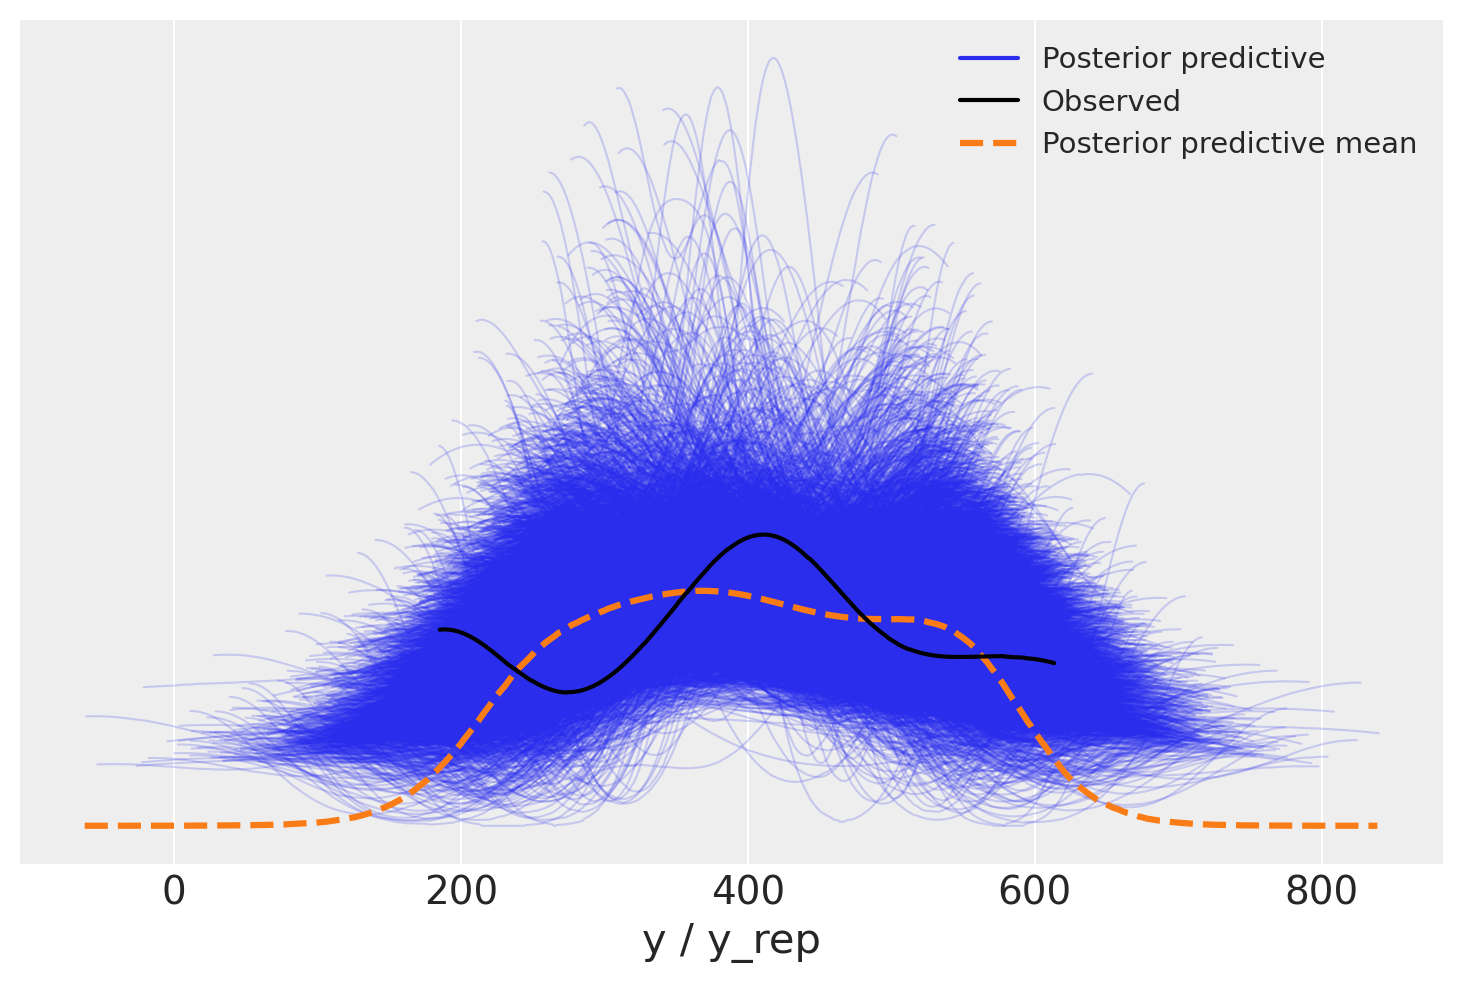

In [28]:
_ = az.plot_ppc(idata, data_pairs={"y": "y_rep"})

## Commenti e considerazioni finali

In questo capitolo abbiamo esplorato la stima dei parametri di un modello di regressione bivariato utilizzando l'approccio bayesiano.

Per fornire un confronto con un metodo alternativo, in appendice è presentata un'introduzione all'approccio frequentista per il modello di regressione lineare bivariato. Questa sezione aggiuntiva offre una panoramica degli aspetti chiave dell'approccio frequentista, consentendo di confrontare e comprendere le differenze tra i due approcci nella stima dei parametri e nell'interpretazione dei risultati.

## Informazioni sull'Ambiente di Sviluppo

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -m

Last updated: Sat Jul 13 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.8.4
cmdstanpy : 1.2.3
arviz     : 0.18.0
pandas    : 2.2.2
numpy     : 1.26.4
pingouin  : 0.5.4
logging   : 0.5.1.2

